In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd

In [2]:
# Open CAPE data
cape = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']

In [3]:
# Open S06 data
s06 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']

In [4]:
# Open NDSEV data
ndsev = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__']

In [75]:
# Need to compute monthly means
ndsev_monthly = np.zeros((255, 101, 237))
for i in range(85):
    # Load in one year of data
    ndsev_load = ndsev.isel(time=slice(i*92, (i+1)*92)).transpose('time', 'latitude', 'longitude').values

    # Sum up NDSEV for Mar, Apr, May, respectively
    ndsev_monthly[i*3] = ndsev_load[0:31].sum(axis=0)
    ndsev_monthly[i*3+1] = ndsev_load[31:61].sum(axis=0)
    ndsev_monthly[i*3+2] = ndsev_load[61:].sum(axis=0)
    
    # Progress
    print(f'{1940+i} is complete.')

1940 is complete.
1941 is complete.
1942 is complete.
1943 is complete.
1944 is complete.
1945 is complete.
1946 is complete.
1947 is complete.
1948 is complete.
1949 is complete.
1950 is complete.
1951 is complete.
1952 is complete.
1953 is complete.
1954 is complete.
1955 is complete.
1956 is complete.
1957 is complete.
1958 is complete.
1959 is complete.
1960 is complete.
1961 is complete.
1962 is complete.
1963 is complete.
1964 is complete.
1965 is complete.
1966 is complete.
1967 is complete.
1968 is complete.
1969 is complete.
1970 is complete.
1971 is complete.
1972 is complete.
1973 is complete.
1974 is complete.
1975 is complete.
1976 is complete.
1977 is complete.
1978 is complete.
1979 is complete.
1980 is complete.
1981 is complete.
1982 is complete.
1983 is complete.
1984 is complete.
1985 is complete.
1986 is complete.
1987 is complete.
1988 is complete.
1989 is complete.
1990 is complete.
1991 is complete.
1992 is complete.
1993 is complete.
1994 is complete.
1995 is co

In [76]:
# Select the CONUS
cape_conus = cape.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
s06_conus  = s06.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [77]:
# Select MAM only
cape_conus_mam = cape_conus.sel(date=cape_conus.date.where(
                                     cape_conus.date.str.startswith('03-') |
                                     cape_conus.date.str.startswith('04-') |
                                     cape_conus.date.str.startswith('05-'),
                                     drop=True)).load()

s06_conus_mam = s06_conus.sel(time=s06_conus.time.dt.month.isin([3, 4, 5]))

In [78]:
# Flatten to have a single time dimension
cape_conus_mam_mean_stack = cape_conus_mam.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_conus_mam_mean_stack['time'].get_index('time').get_level_values('year')
date = cape_conus_mam_mean_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_conus_mam_mean_stack = cape_conus_mam_mean_stack.assign_coords(time=datetime)

/tmp/ipykernel_23599/906048647.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_conus_mam_mean_stack = cape_conus_mam_mean_stack.assign_coords(time=datetime)


In [82]:
# Take MAM mean
s06_conus_mam_mean = s06_conus_mam.resample(time='ME').mean().dropna(dim='time')
cape_conus_mam_mean = cape_conus_mam_mean_stack.resample(time='ME').mean().dropna(dim='time').transpose('time', 'latitude', 'longitude')

In [84]:
# Convert ndsev_monthly to XR
ndsev_conus = xr.DataArray(ndsev_monthly, coords={'time':cape_conus_mam_mean['time'], 'latitude':s06_conus_mam_mean['latitude'], 'longitude':s06_conus_mam_mean['longitude']}, dims=['time', 'latitude', 'longitude'])

In [85]:
# Detrend
cape_conus_mam_de = pdo_functions.detrend_dim(cape_conus_mam_mean, 'time', 2)
s06_conus_mam_de  = pdo_functions.detrend_dim(s06_conus_mam_mean, 'time', 2).load()
ndsev_conus_mam_de = pdo_functions.detrend_dim(ndsev_conus, 'time', 2)

In [25]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [26]:
# Standardize Nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [86]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()

nino_34_calc = np.zeros((1860))
for i in range(1860):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':sst['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

# Need to calculate when El Nino/La Nina Occurs in a given year
# nino_34_1940_2024_mam_ann = np.zeros((85))
# for i in range(85):
#     if nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
#         nino_34_1940_2024_mam_ann[i] = 1

#     elif nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
#         nino_34_1940_2024_mam_ann[i] = -1

#     else:
#         continue
nino_34_1940_2024_mam_ann = np.zeros((255))
for i in range(255):
    if nino_34_1940_2024_mam[i] > 0:
        nino_34_1940_2024_mam_ann[i] = 1

    elif nino_34_1940_2024_mam[i] < 0:
        nino_34_1940_2024_mam_ann[i] = -1

    else:
        continue

In [87]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5]))#.resample(time='YE').mean()
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))#.resample(time='YE').mean()

# aligning time arrays with that of CAPE
pdo_1940_2024_mam['time'] = cape_conus_mam_de['time']
nino_34_1940_2024_mam['time'] = cape_conus_mam_de['time']

s06_conus_mam_de['time'] = cape_conus_mam_de['time']

In [88]:
# Compositing
cape_pos_pdo = xr.where(pdo_1940_2024_mam > 0, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_pdo = xr.where(pdo_1940_2024_mam < -0, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_nino = xr.where(nino_34_1940_2024_mam > 0, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_nino = xr.where(nino_34_1940_2024_mam < -0, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < -0) & (nino_34_1940_2024_mam_ann == 0), cape_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_pdo = xr.where(pdo_1940_2024_mam > 0, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_pdo = xr.where(pdo_1940_2024_mam < 0, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_nino = xr.where(nino_34_1940_2024_mam > 0, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_nino = xr.where(nino_34_1940_2024_mam < 0, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), s06_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_pdo = xr.where(pdo_1940_2024_mam < 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_nino = xr.where(nino_34_1940_2024_mam > 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_nino = xr.where(nino_34_1940_2024_mam < 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), ndsev_conus_mam_de, np.nan).dropna(dim='time')

In [89]:
# Load full colormap
cmap_full = cmr.fusion_r
cmap_full_other = cmr.fusion

# Extract first half (lower values)
cmap_half = c.LinearSegmentedColormap.from_list(
    'fusion_r_half',
    cmap_full(np.linspace(0.5, 1.0, 256))
)

cmap_other_half = c.LinearSegmentedColormap.from_list(
    'fusion_r_half',
    cmap_full_other(np.linspace(0.5, 1.0, 256))
)

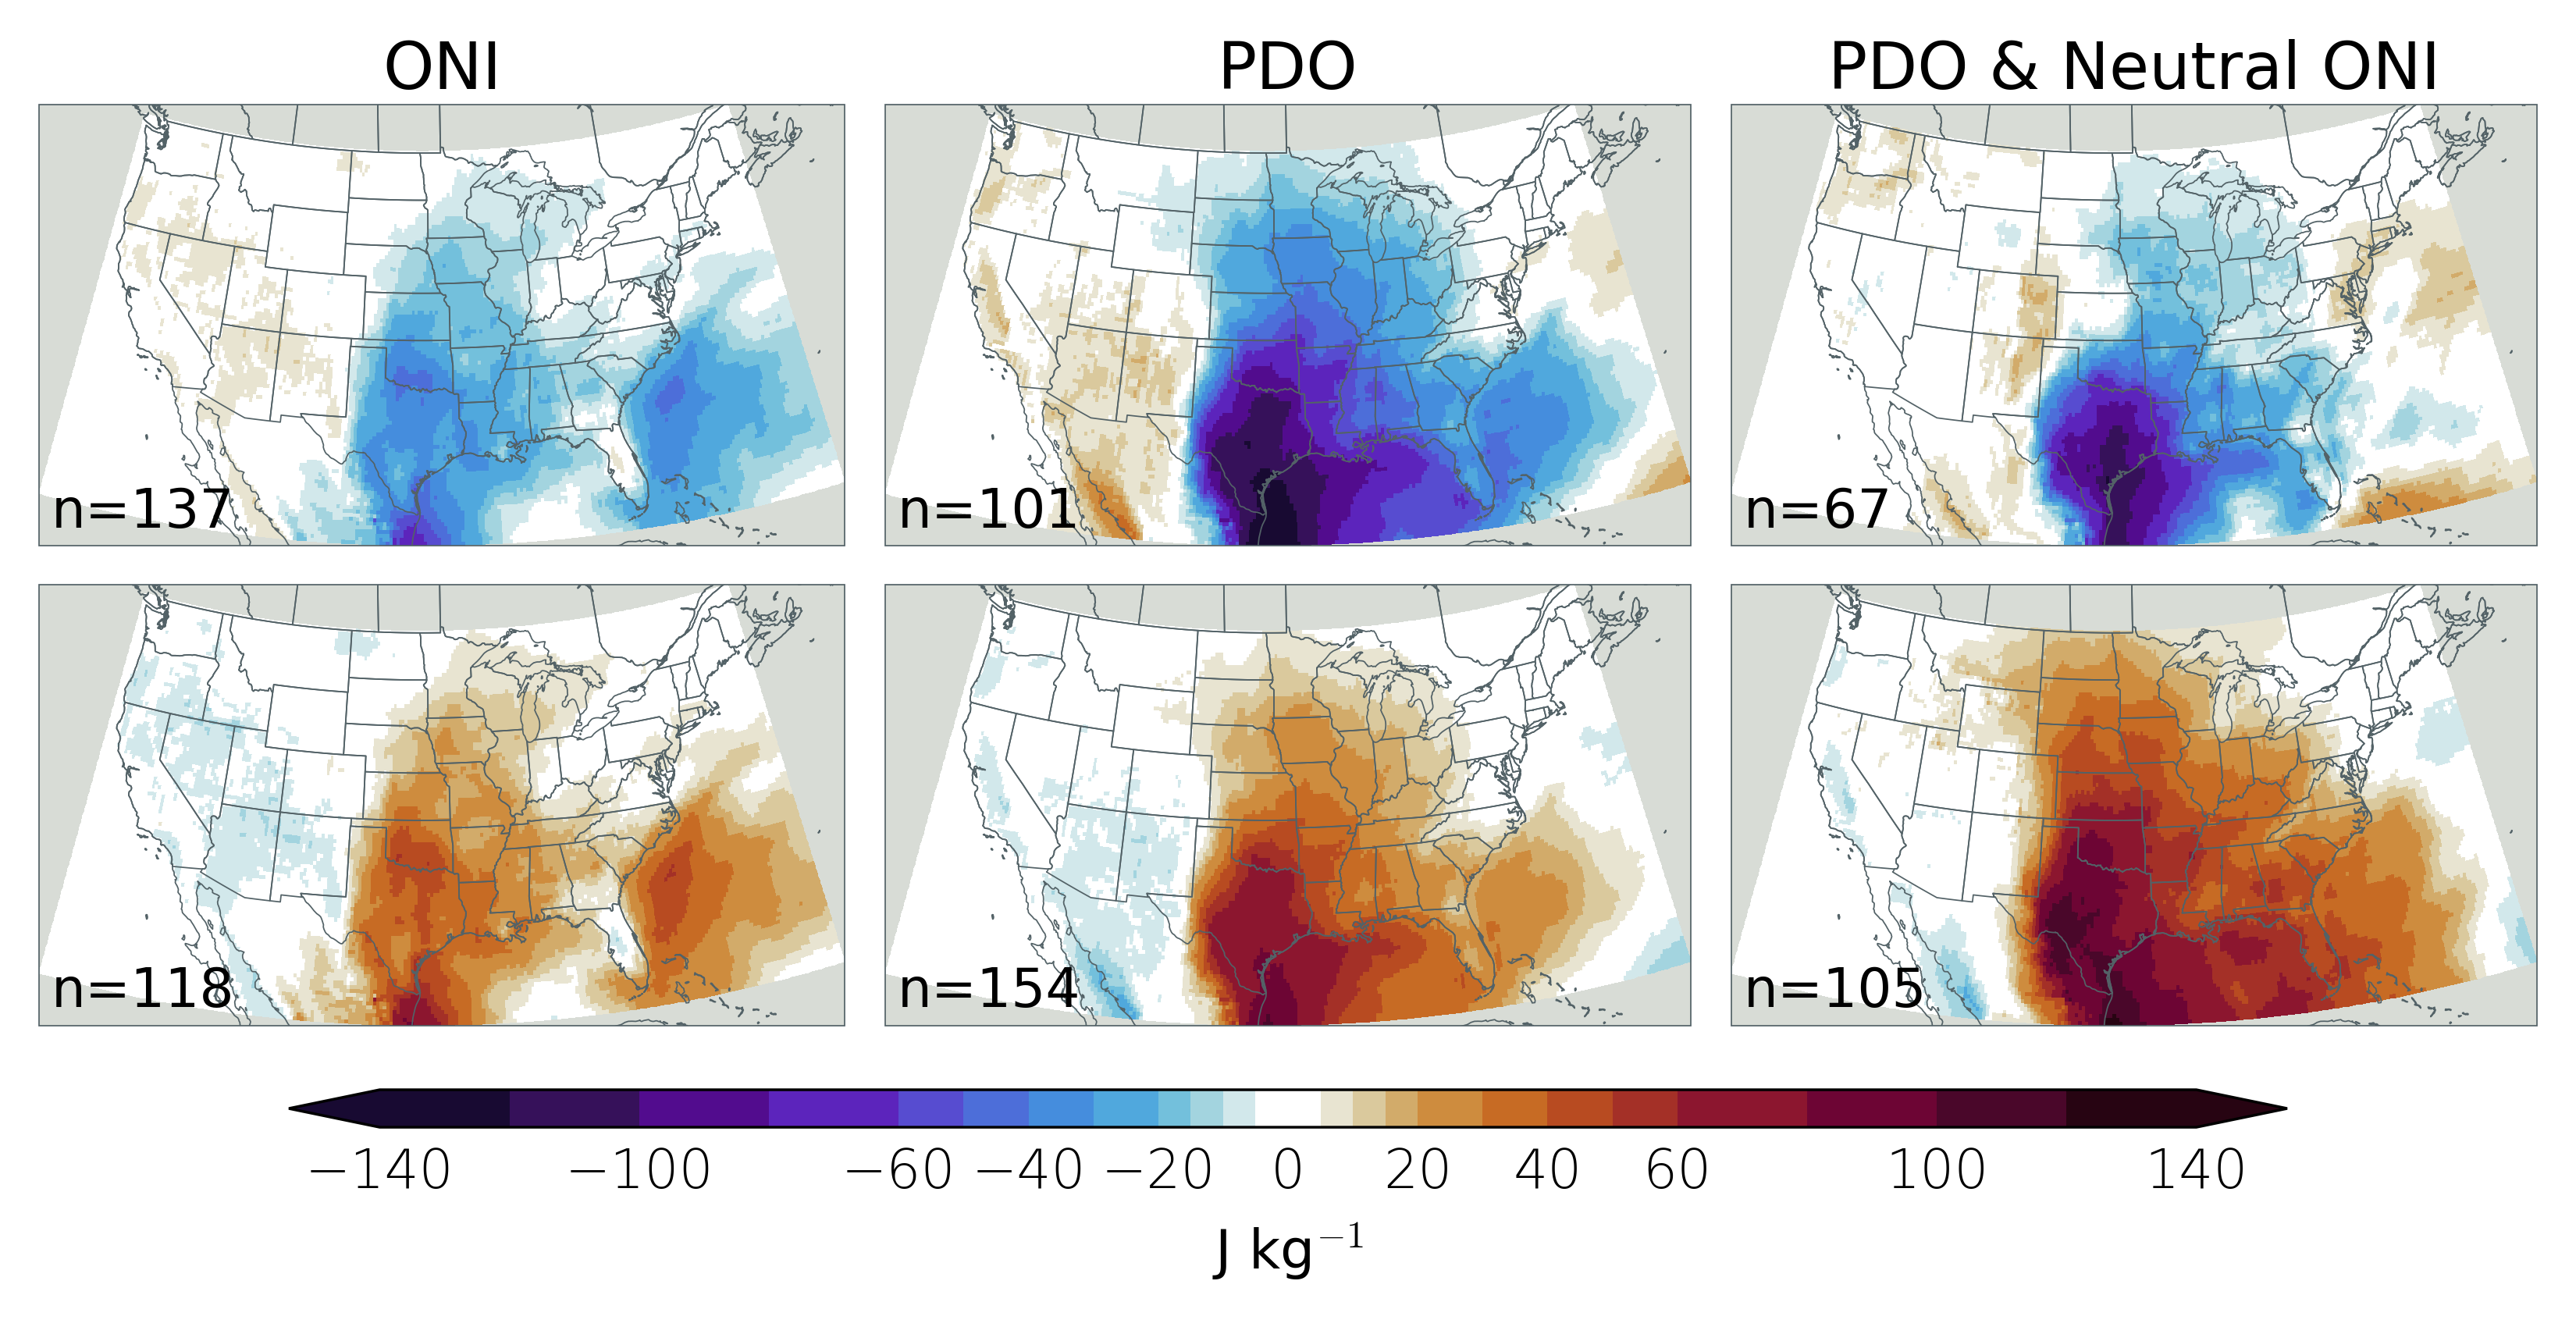

In [90]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-140, -120, -100, -80, -60, -50, -40, -30, -20, -15, -10, -5, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100, 120, 140]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

lat = cape_conus_mam_de['latitude']
lon = cape_conus_mam_de['longitude']

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon, lat, cape_pos_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(lon, lat, cape_neg_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(lon, lat, cape_pos_pdo.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(lon, lat, cape_neg_pdo.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(lon, lat, cape_pos_pdo_neut_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(lon, lat, cape_neg_pdo_neut_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('ONI', pad=3)
ax[1].set_title('PDO', pad=3)
ax[2].set_title('PDO & Neutral ONI', pad=3)

cax = plt.axes([0.1, .2, 0.8, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-140, -100, -60, -40, -20, 0, 20, 40, 60, 100, 140])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].text(-2700000, -1300000, f'n={len(cape_pos_nino)}', fontweight='normal')
ax[3].text(-2700000, -1300000, f'n={len(cape_neg_nino)}', fontweight='normal')

ax[1].text(-2700000, -1300000, f'n={len(cape_pos_pdo)}', fontweight='normal')
ax[4].text(-2700000, -1300000, f'n={len(cape_neg_pdo)}', fontweight='normal')

ax[2].text(-2700000, -1300000, f'n={len(cape_pos_pdo_neut_nino)}', fontweight='normal')
ax[5].text(-2700000, -1300000, f'n={len(cape_neg_pdo_neut_nino)}', fontweight='normal')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

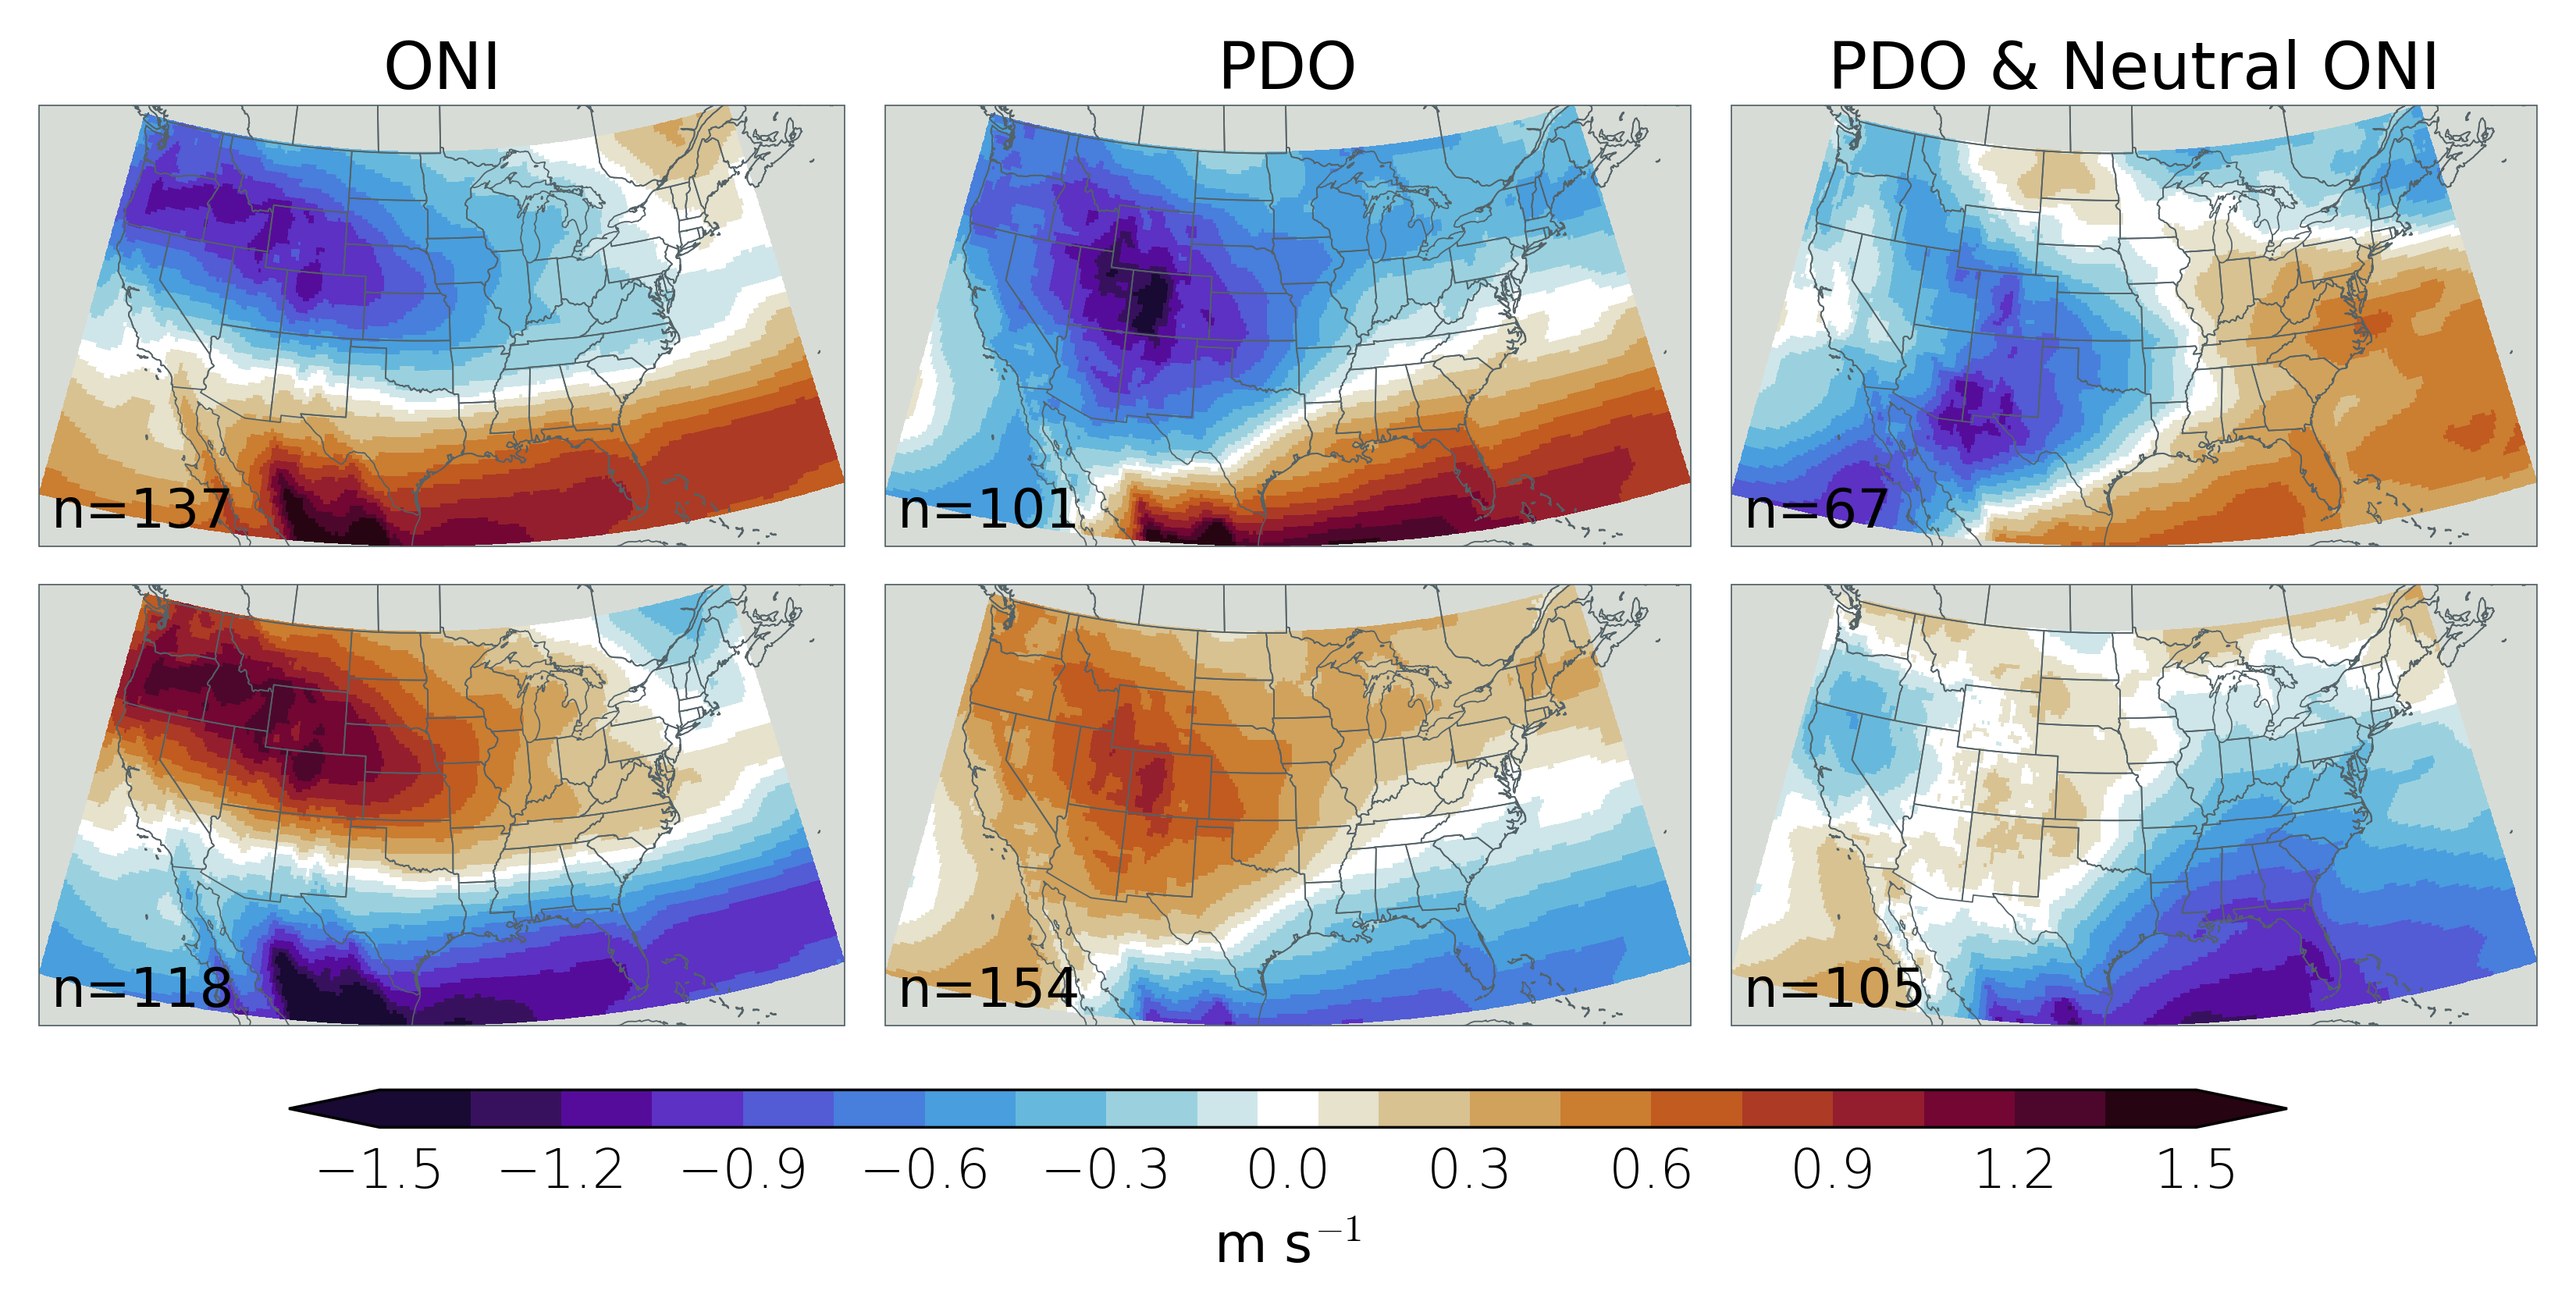

In [91]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-1.5, -1.35, -1.2, -1.05, -0.9, -0.75, -0.6, -0.45, -0.3, -0.15, -0.05, 0.05, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

lat = cape_conus_mam_de['latitude']
lon = cape_conus_mam_de['longitude']

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon, lat, s06_pos_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(lon, lat, s06_neg_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(lon, lat, s06_pos_pdo.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(lon, lat, s06_neg_pdo.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(lon, lat, s06_pos_pdo_neut_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(lon, lat, s06_neg_pdo_neut_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('ONI', pad=3)
ax[1].set_title('PDO', pad=3)
ax[2].set_title('PDO & Neutral ONI', pad=3)

cax = plt.axes([0.1, .2, 0.8, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-1.5, -1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2, 1.5])
cbar.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].text(-2700000, -1300000, f'n={len(s06_pos_nino)}', fontweight='normal')
ax[3].text(-2700000, -1300000, f'n={len(s06_neg_nino)}', fontweight='normal')

ax[1].text(-2700000, -1300000, f'n={len(s06_pos_pdo)}', fontweight='normal')
ax[4].text(-2700000, -1300000, f'n={len(s06_neg_pdo)}', fontweight='normal')

ax[2].text(-2700000, -1300000, f'n={len(s06_pos_pdo_neut_nino)}', fontweight='normal')
ax[5].text(-2700000, -1300000, f'n={len(s06_neg_pdo_neut_nino)}', fontweight='normal')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

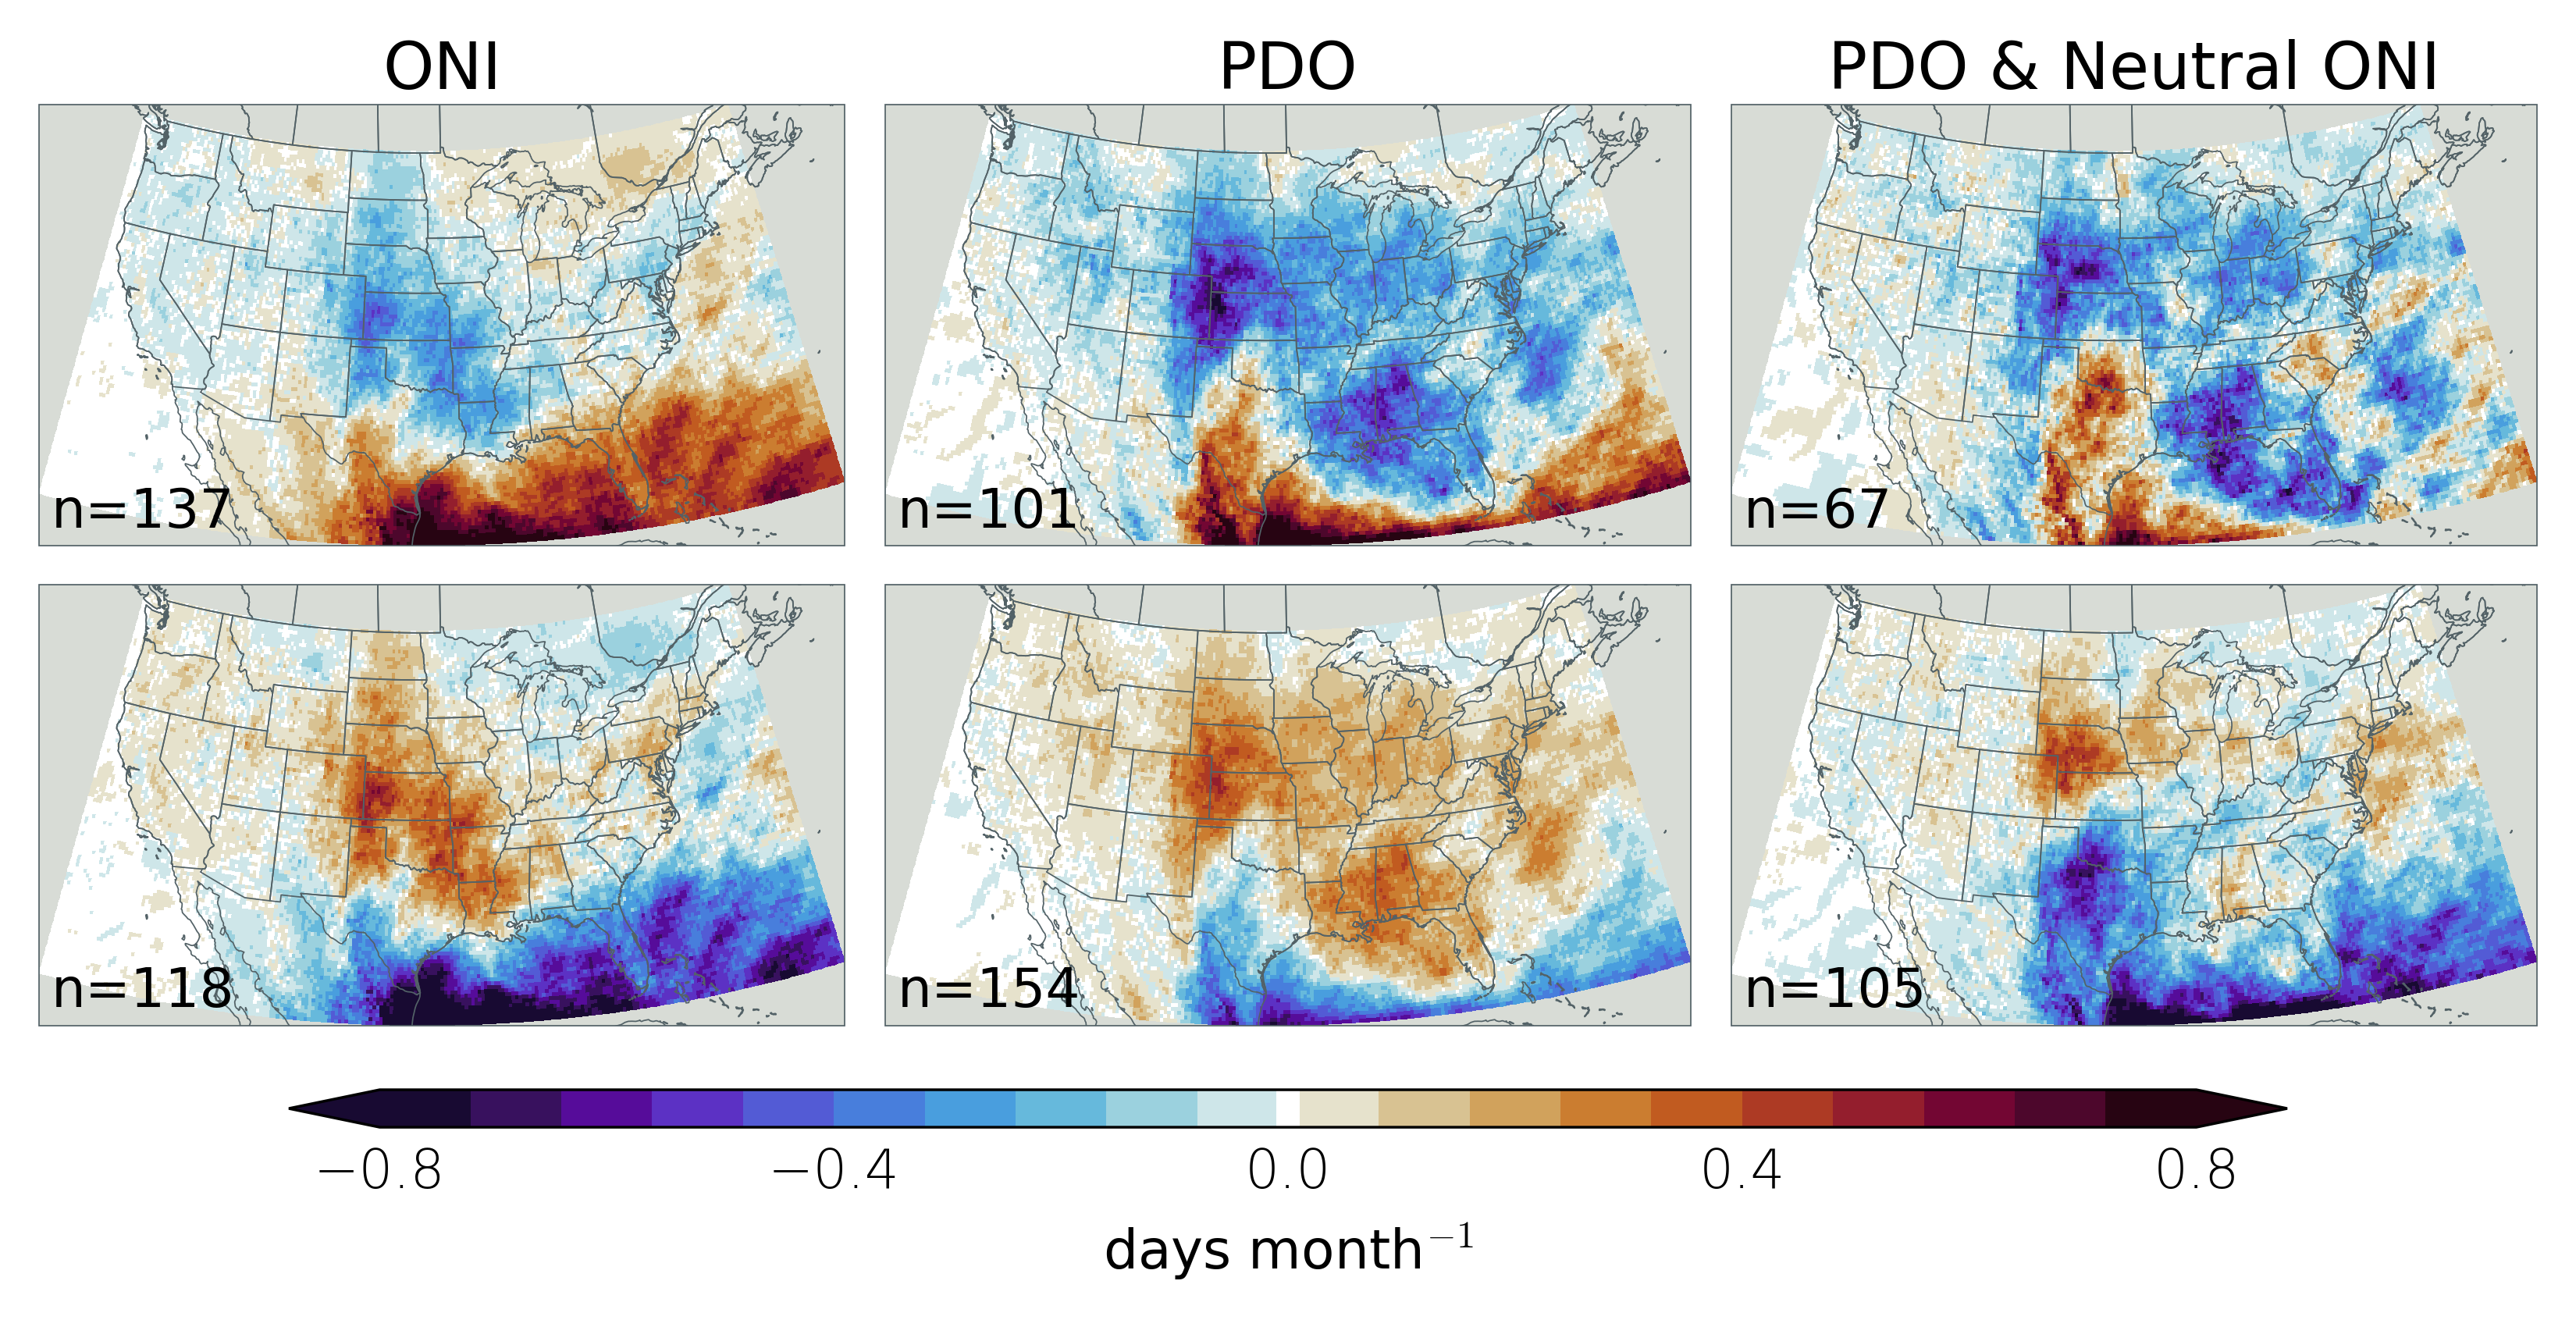

In [96]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-0.8, -0.72, -0.64, -0.56, -0.48, -0.4, -0.32, -0.24, -0.16, -0.08, -0.01, 0.01, 0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

lat = cape_conus_mam_de['latitude']
lon = cape_conus_mam_de['longitude']

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon, lat, ndsev_pos_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(lon, lat, ndsev_neg_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(lon, lat, ndsev_pos_pdo.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(lon, lat, ndsev_neg_pdo.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(lon, lat, ndsev_pos_pdo_neut_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(lon, lat, ndsev_neg_pdo_neut_nino.mean(dim='time', skipna=True), transform=ccrs.PlateCarree(), shading='auto', cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('ONI', pad=3)
ax[1].set_title('PDO', pad=3)
ax[2].set_title('PDO & Neutral ONI', pad=3)

cax = plt.axes([0.1, .2, 0.8, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6, 2])
cbar.set_label(r'days month$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].text(-2700000, -1300000, f'n={len(ndsev_pos_nino)}', fontweight='normal')
ax[3].text(-2700000, -1300000, f'n={len(ndsev_neg_nino)}', fontweight='normal')

ax[1].text(-2700000, -1300000, f'n={len(ndsev_pos_pdo)}', fontweight='normal')
ax[4].text(-2700000, -1300000, f'n={len(ndsev_neg_pdo)}', fontweight='normal')

ax[2].text(-2700000, -1300000, f'n={len(ndsev_pos_pdo_neut_nino)}', fontweight='normal')
ax[5].text(-2700000, -1300000, f'n={len(ndsev_neg_pdo_neut_nino)}', fontweight='normal')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)